In [5]:
import os
os.chdir('C:/Users/Zeddrex Navarra/Desktop/Career/Trial Codes/znavarra.github.io')

In [6]:
import os
current_dir = os.getcwd()
print(current_dir)

C:\Users\Zeddrex Navarra\Desktop\Career\Trial Codes\znavarra.github.io


In [8]:
import pyreadr

rds_file_path = 'LEGAZPI.rds'
result = pyreadr.read_r(rds_file_path)
weather = result[None]
print(weather.head())

         DATE  PRCP  TEMP   MIN   MAX
0  1973-01-01   0.0  82.0  77.0  84.2
1  1973-01-02   NaN  80.3  75.2  86.0
2  1973-01-03   NaN  78.5  71.6  84.2
3  1973-01-04   NaN  81.1  78.8  82.4
4  1973-01-05   NaN  81.0  78.8  84.2


#### Preliminary Look at the Data

Let's take a look at the summary information for our data

In [9]:
import pandas as pd

summary_weather = weather.describe()
missing_data = weather.isnull().sum()
missing_data.name = 'missing_count'
combined_data = pd.concat([summary_weather, missing_data], axis=1)
print(combined_data)


               PRCP          TEMP           MIN           MAX  missing_count
count  14968.000000  17340.000000  17217.000000  17324.000000            NaN
mean       0.360034     81.224769     75.567172     87.316203            NaN
std        0.828537      3.167727      3.908172      3.641252            NaN
min        0.000000     44.400000     32.000000     73.400000            NaN
25%        0.000000     79.600000     74.500000     85.100000            NaN
50%        0.040000     81.500000     76.100000     87.800000            NaN
75%        0.350000     83.200000     77.200000     89.600000            NaN
max       17.230000     92.900000     86.000000    111.200000            NaN
DATE            NaN           NaN           NaN           NaN            0.0
PRCP            NaN           NaN           NaN           NaN         2372.0
TEMP            NaN           NaN           NaN           NaN            0.0
MIN             NaN           NaN           NaN           NaN          123.0

There are 2372 cells out of 17340 with missing data for precipitation

In [10]:
print(weather.tail())

             DATE  PRCP  TEMP   MIN   MAX
17335  2022-11-17  2.32  80.0  77.0  86.5
17336  2022-11-18  0.94  78.5  76.6  80.2
17337  2022-11-19  3.69  77.7  76.1  81.3
17338  2022-11-20  0.48  79.1  75.0  81.7
17339  2022-11-21  0.00  82.3  77.0  89.6


Due to natural disasters there are a number of months or even years where the data was lost.

#### Completing the Data

In [15]:
import pandas as pd
from pandasql import sqldf

# Assuming 'weather' is your DataFrame with columns DATE, PRCP, MAX, TEMP, and MIN

# Create a sequence of dates
timeseries = pd.date_range(start=min(weather['DATE']), end=max(weather['DATE']), freq='D')
dates = pd.DataFrame({'DATE': timeseries})

weather['DATE'] = pd.to_datetime(weather['DATE'])

# Perform a full join and arrange by DATE
compweather = pd.merge(dates, weather, on='DATE', how='outer').sort_values(by='DATE')

compweather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18222 entries, 0 to 18221
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    18222 non-null  datetime64[ns]
 1   PRCP    14968 non-null  float64       
 2   TEMP    17340 non-null  float64       
 3   MIN     17217 non-null  float64       
 4   MAX     17324 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 711.9 KB


In [16]:
# Filter rows with missing data for PRCP, MAX, TEMP, and MIN
missing_data = compweather[(compweather['PRCP'].isnull()) &
                           (compweather['MAX'].isnull()) &
                           (compweather['TEMP'].isnull()) &
                           (compweather['MIN'].isnull())]

# Calculate number of missing values per year for PRCP
number = missing_data.assign(YEAR=missing_data['DATE'].dt.year) \
                     .groupby('YEAR') \
                     .agg(No_of_Missing=('PRCP', lambda x: x.isnull().sum())) \
                     .sort_values(by='No_of_Missing', ascending=False)

print(number.head())

      No_of_Missing
YEAR               
1976            121
1983            113
1982             82
1977             69
2001             63


In [19]:
compweather.fillna(0, inplace=True)

# Calculate total rainfall maxima and total rainfall per year
total = compweather.assign(Year=compweather['DATE'].dt.year) \
                   .groupby('Year') \
                   .agg(Rainfall_Maxima=('PRCP', 'max'),
                        Rainfall_Total=('PRCP', 'sum')) \
                   .reset_index()

head_tail_df = pd.concat([total.head(), total.tail()])
print(head_tail_df)

    Year  Rainfall_Maxima  Rainfall_Total
0   1973             3.66           74.44
1   1974             8.82          109.18
2   1975             7.87           82.42
3   1976             4.72           59.38
4   1977             5.79           81.68
45  2018             9.64          155.64
46  2019             8.80           94.91
47  2020            11.13          150.07
48  2021             7.41          145.32
49  2022             4.28          120.26


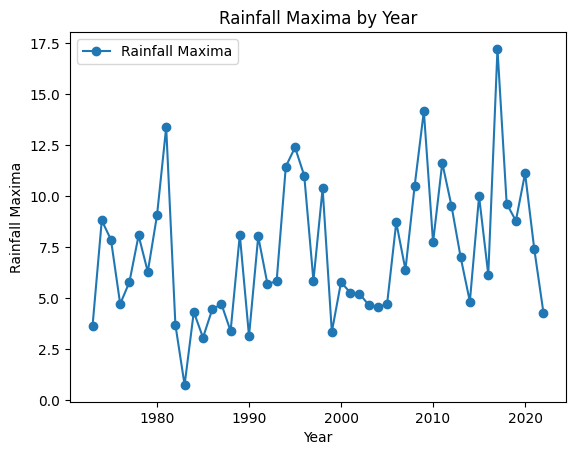

In [20]:
import matplotlib.pyplot as plt

# Assuming 'total' is your DataFrame with columns Year and Rainfall_Maxima

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(total['Year'], total['Rainfall_Maxima'], label='Rainfall Maxima', marker='o')

# Set the labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Rainfall Maxima')
ax.set_title('Rainfall Maxima by Year')

# Add a legend
ax.legend()

# Show the plot
plt.show()


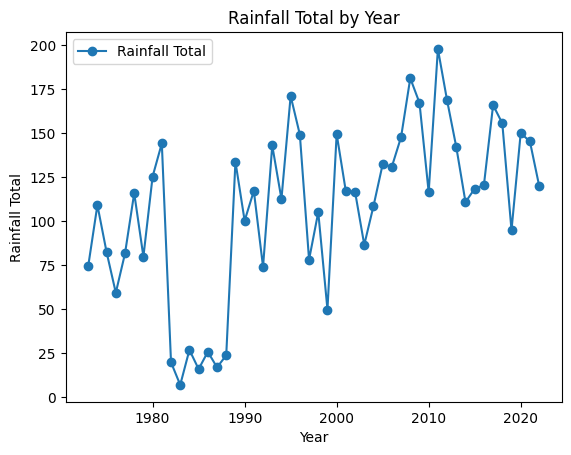

In [21]:
# Assuming 'total' is your DataFrame with columns Year and Rainfall_Maxima

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(total['Year'], total['Rainfall_Total'], label='Rainfall Total', marker='o')

# Set the labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Rainfall Total')
ax.set_title('Rainfall Total by Year')

# Add a legend
ax.legend()

# Show the plot
plt.show()

#### Let's see how the graph would look like if we remove or replace the missing data